In [9]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
path = r"c:\Users\Sushree S Swain\Desktop\Brain Tumour All"
image_paths = list(paths.list_images(path))

In [10]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

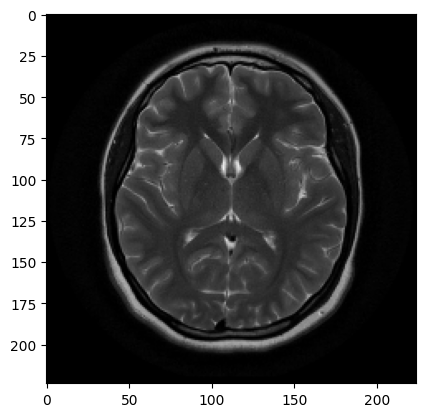

In [11]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [12]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [13]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [15]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

80134624/80134624 [==============================] - 23s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 30

In [20]:
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

C:\Users\Sushree S Swain\AppData\Local\Temp\ipykernel_32140\504464780.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)


Epoch 1/30
56/56 [==============================] - 130s 2s/step - loss: 0.6859 - accuracy: 0.5996 - val_loss: 0.6095 - val_accuracy: 0.8235
Epoch 2/30
56/56 [==============================] - 114s 2s/step - loss: 0.6100 - accuracy: 0.6667 - val_loss: 0.5475 - val_accuracy: 0.6667
Epoch 3/30
56/56 [==============================] - 126s 2s/step - loss: 0.5773 - accuracy: 0.7136 - val_loss: 0.5155 - val_accuracy: 0.8431
Epoch 4/30
56/56 [==============================] - 120s 2s/step - loss: 0.5451 - accuracy: 0.7606 - val_loss: 0.4593 - val_accuracy: 0.8824
Epoch 5/30
56/56 [==============================] - 118s 2s/step - loss: 0.5320 - accuracy: 0.7606 - val_loss: 0.4313 - val_accuracy: 0.8627
Epoch 6/30
56/56 [==============================] - 112s 2s/step - loss: 0.5090 - accuracy: 0.7584 - val_loss: 0.3988 - val_accuracy: 0.8627
Epoch 7/30
56/56 [==============================] - 120s 2s/step - loss: 0.4984 - accuracy: 0.7763 - val_loss: 0.3675 - val_accuracy: 0.8824
Epoch 8/30
56

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

7/7 [==============================] - 18s 2s/step
              precision    recall  f1-score   support

          no       1.00      0.85      0.92        20
         yes       0.91      1.00      0.95        31

    accuracy                           0.94        51
   macro avg       0.96      0.93      0.94        51
weighted avg       0.95      0.94      0.94        51

[[17  3]
 [ 0 31]]


In [22]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 94.12%


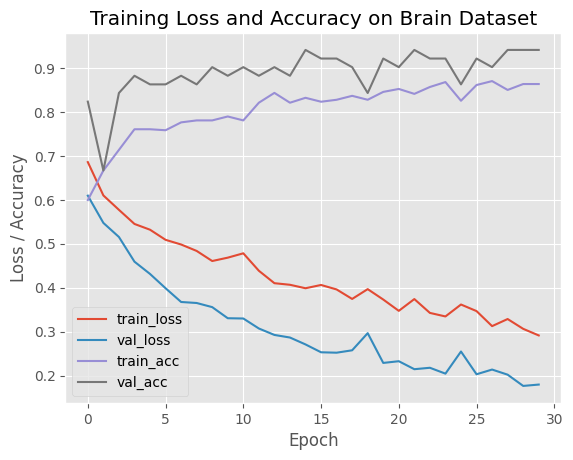

In [23]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

In [24]:
confusion_matrix = test_X.confusion_matrix(test_X, test_Y)

cm_display = test_X.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'confusion_matrix'